## In this notebook, we walk through the thought process to find useful features. 
In this particular example, the useful feature is rolling mean.
### 1. study the mispredictions of the previous baseline xgb model.
### 2. visualize patterns and find transformations to bring out the pattern.
### 3. confirm the effectiveness of new features by cross validation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def _plot_subplot(ax, x, y, loss, loc, mi):
    """Helper function to plot a single subplot."""
    indices = np.arange(len(x)) + mi
    ax.bar(indices, x, color='dimgray', alpha=0.9)

    red_indices = np.where(y == 1)[0] + mi
    if red_indices.size > 0:
        red_index = red_indices[0]
    else:
        raise ValueError(f"No index found where y == 1 in {title_suffix}.")

    blue_index = np.argmax(x) + mi

    ylim = ax.get_ylim()
    dot_y = ylim[1]

    col = x.name
    ax.scatter(red_index, dot_y, color='red', s=100, edgecolors='black', alpha=0.7, label='flood==1')
    ax.scatter(blue_index, dot_y, color='blue', s=100, edgecolors='black', alpha=0.7, label=f'max({col})')

    distance = abs(red_index - blue_index)
    midpoint = (red_index + blue_index) / 2.0
    text_y = dot_y * 0.95

    text_obj = ax.text(
        midpoint, text_y,
        f"Distance: {distance}",
        ha='center',
        va='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
    )

    fig = plt.gcf() # Get current figure to draw canvas
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bbox_text = text_obj.get_window_extent(renderer=renderer)
    ax_data_bbox = bbox_text.transformed(ax.transData.inverted())

    left_edge = ax_data_bbox.x0
    right_edge = ax_data_bbox.x1
    arrow_y = (ax_data_bbox.y0 + ax_data_bbox.y1) / 2.0

    arrow_start_x_red = left_edge if red_index < midpoint else right_edge
    arrow_start_x_blue = left_edge if blue_index < midpoint else right_edge

    ax.annotate("", xy=(red_index, arrow_y), xytext=(arrow_start_x_red, arrow_y),
                arrowprops=dict(arrowstyle="->", color='red', lw=2))
    ax.annotate("", xy=(blue_index, arrow_y), xytext=(arrow_start_x_blue, arrow_y),
                arrowprops=dict(arrowstyle="->", color='blue', lw=2))

    
    ax.set_xlabel('day')
    ax.set_ylabel(col)
    ax.set_title(f'{col} data of Location {loc} logloss={loss:.4f}')
    ax.legend()


def plot_two_locations(x1, y1, x2, y2, loss1, loss2, loc1, loc2, mi):
    """Plots two locations in a 1x2 subplot figure."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    _plot_subplot(ax[0], x1, y1, loss1, loc1, mi)
    _plot_subplot(ax[1], x2, y2, loss2, loc2, mi)

    plt.tight_layout()
    plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_rolling_mean(data, loc, window_size=10):
    # Generate a sample time series
    np.random.seed(0)
    data = data.reset_index(drop=True)
    # Compute the rolling mean
    rolling_mean = data.rolling(window=window_size).mean()
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the original data
    plt.plot(data.index, data, marker='o', linestyle='-', label='Original Data', alpha=0.6)
    
    # Plot the rolling mean
    plt.plot(rolling_mean.index, rolling_mean, color='red', linewidth=2,
             label=f'Rolling Mean (window={window_size})')
    
    # --- Visualize a specific rolling window ---
    # Choose a target index where the rolling mean is computed (must be >= window_size-1)
    target_index = 180
    
    # The rolling mean at target_index is computed from data[target_index-window_size+1] to data[target_index]
    window_indices = list(range(target_index - window_size + 1, target_index + 1))
    window_data = data.iloc[window_indices]
    
    # Highlight the data points included in this window
    plt.scatter(window_indices, window_data, color='green', s=100,
                zorder=5, label='Window Data Points')
    
    # Draw a semi-transparent rectangle over the window region
    plt.axvspan(window_indices[0] - 0.5, window_indices[-1] + 0.5, color='yellow', alpha=0.3)
    
    # Calculate the average for this window and annotate it on the plot
    window_avg = window_data.mean()
    plt.annotate(f'Window Avg: {window_avg:.2f}', 
                 xy=(target_index, rolling_mean.iloc[target_index]), 
                 xytext=(target_index + 5, rolling_mean.iloc[target_index] + 5),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12, backgroundcolor='w')
    
    # Add labels, title, legend, and grid
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Visualization of Rolling Mean of Precipitation of Location {loc}')
    plt.legend()
    plt.grid(True)
    plt.show()


### Look at the CV prediction of previous model

In [3]:
PATH = '/raid/ml/flood'
from xgb_helper import XGBHelper
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedGroupKFold

In [4]:
train = pd.read_csv('../xgb_baseline_02_18_2025/cv_xgb_baseline.csv')
train['logloss'] = -train['label'] * np.log(train['prob']) - (1 - train['label']) * np.log(1 - train['prob'])
train.head()

,event_id,precipitation,label,day,location,prob,logloss
0,id_spictby0jfsb_X_0,0.000000,0,0,spictby0jfsb,0.000024,0.000024
1,id_spictby0jfsb_X_1,0.095438,0,1,spictby0jfsb,0.000026,0.000026
2,id_spictby0jfsb_X_2,1.949560,0,2,spictby0jfsb,0.000035,0.000035
3,id_spictby0jfsb_X_3,3.232160,0,3,spictby0jfsb,0.000036,0.000036
4,id_spictby0jfsb_X_4,0.000000,0,4,spictby0jfsb,0.000024,0.000024


In [5]:
def get_sample_of_loss(mask, col='precipitation', i=0):
    loss = train.loc[mask,'logloss'].values[i]
    loc = train.loc[mask,'location'].values[i]
    m = train.location==loc
    mi,mx = 250,450 # flood event only occurs within this window between day 250 and day 450
    x = train.loc[m, col][mi:mx]
    y = train.loc[m,'label'][mi:mx]
    return x, y, loss, mi, loc

mask = (train.label==1)&(train.logloss>4)
x1, y1, loss1, mi, loc1 = get_sample_of_loss(mask)

mask = (train.label==1)&(train.logloss<2)
x2, y2, loss2, mi, loc2 = get_sample_of_loss(mask)

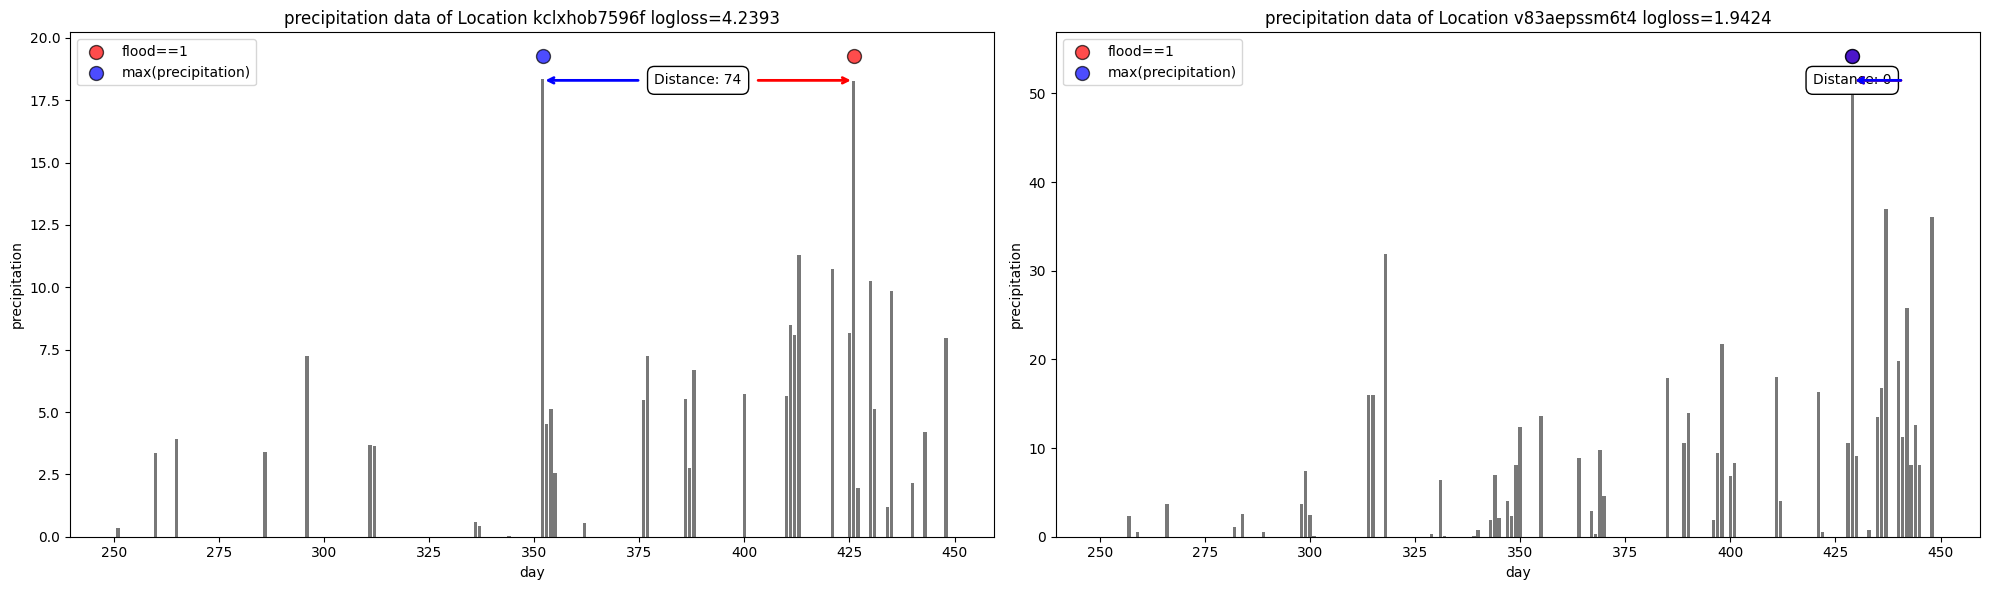

In [6]:
plot_two_locations(x1, y1, x2, y2, loss1, loss2, loc1, loc2, mi)

#### The max precipitation day might not align with the flood event day. 
We should aggregate several days to detect flood event.

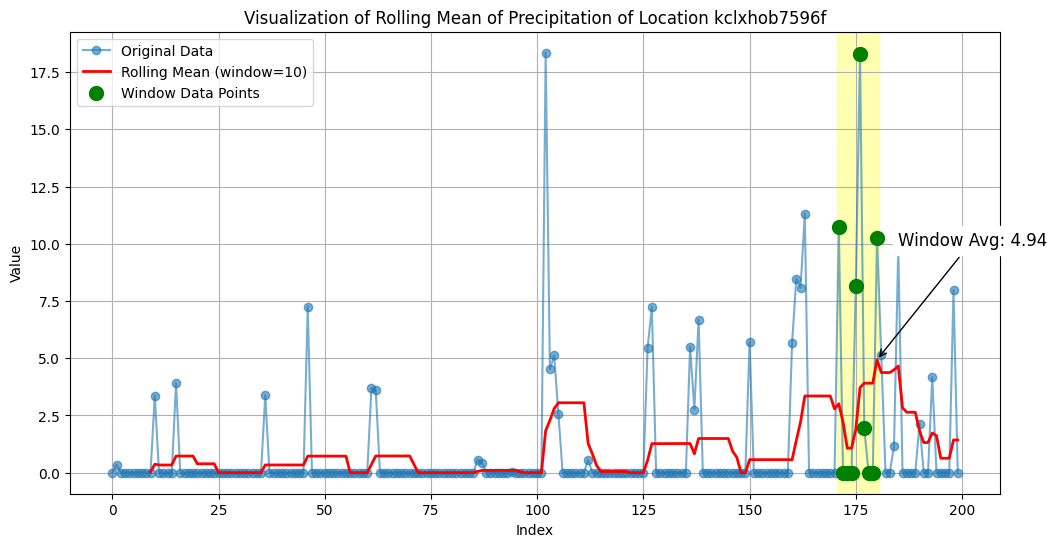

In [7]:
visualize_rolling_mean(x1, loc1)

In [9]:
window_size=10
col = f'rolling_mean_{window_size}'
train[col] = train.groupby('location')['precipitation'].transform(lambda x: x.rolling(window_size).mean())
mask = (train.label==1)&(train.logloss>4)
x1, y1, loss1, mi, loc1 = get_sample_of_loss(mask, col=col)

mask = (train.label==1)&(train.logloss<2)
x2, y2, loss2, mi, loc2 = get_sample_of_loss(mask, col=col)

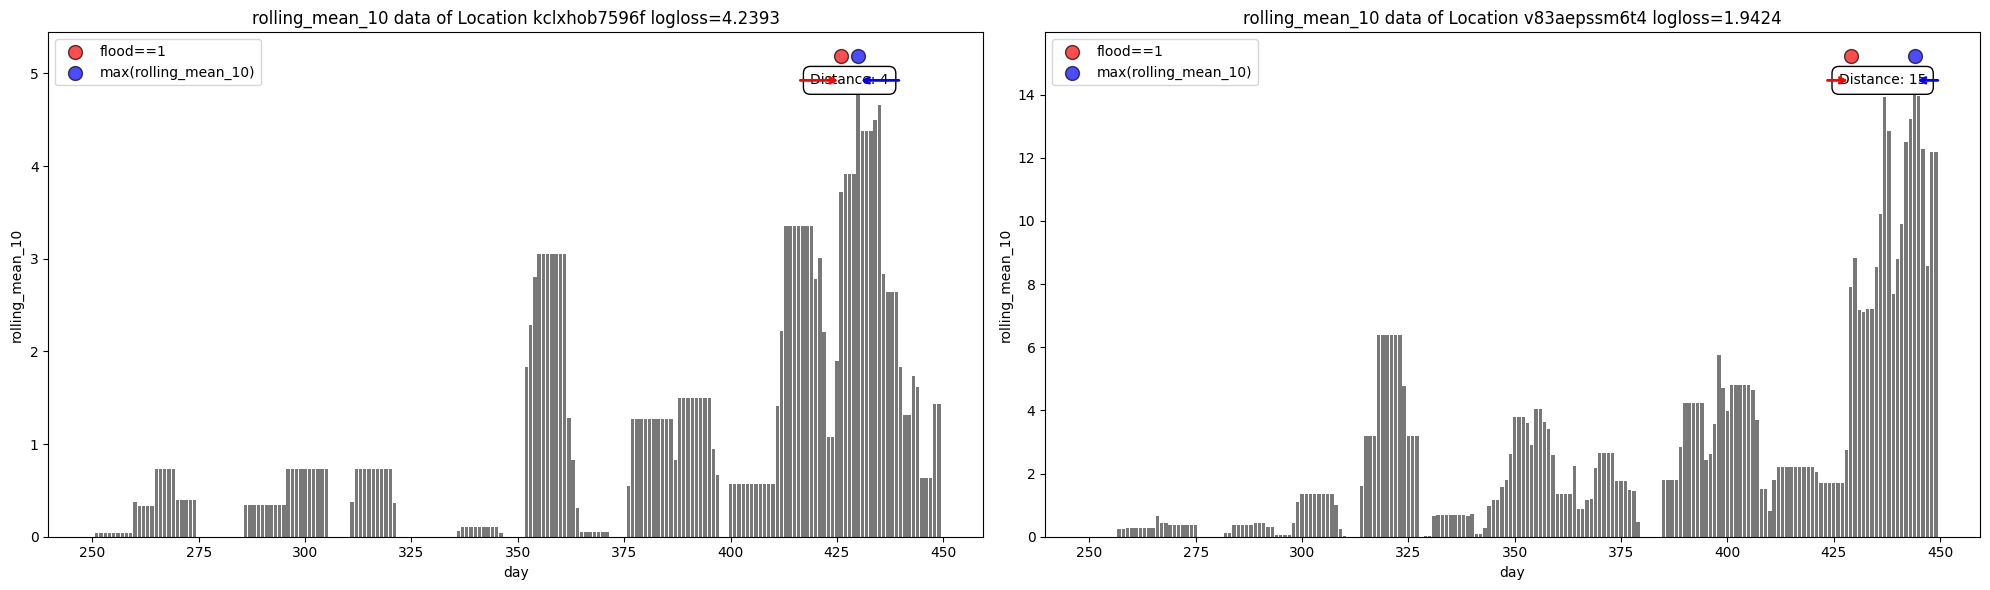

In [10]:
plot_two_locations(x1, y1, x2, y2, loss1, loss2, loc1, loc2, mi)

### Check the usefulness of features by cross validation

In [11]:
train = pd.read_csv(f'{PATH}/Train.csv')
test = pd.read_csv(f'{PATH}/Test.csv')

def feature_engineering(df):
    features = ['day', 'precipitation']
    df['day'] = df['event_id'].apply(lambda x: x.split('_')[-1]).astype(int)
    df['location'] = df['event_id'].apply(lambda x: x.split('_')[1])
    for window_size in range(2,100,2):
        col = f'rolling_mean_{window_size}'
        df[col] = df.groupby('location')['precipitation'].transform(lambda x: x.rolling(window_size).mean())
        features.append(col)
    return df, features

train, feas = feature_engineering(train)
test, feas = feature_engineering(test)

test['prob'] = 0
folds = 4
kf = StratifiedGroupKFold(n_splits=folds)
for i, (tr_idx, val_idx) in enumerate(kf.split(train, train['label'], groups=train['location'])):
    tr = train.iloc[tr_idx]
    val = train.iloc[val_idx]

    xgb = XGBHelper('classification', params={'max_depth': 3, 'eta':0.02,
                                              'subsample':0.5,
                                              'colsample_bytree':1}, 
                    num_boost_rounds=1000,
                    early_stop_rounds=100)
    xgb.fit(tr[feas], tr['label'], val[feas], val['label'])

    train.loc[val_idx,'prob'] = xgb.predict(val[feas])
    test['prob'] += xgb.predict(test[feas])
    score = log_loss(train.loc[val_idx,'label'], train.loc[val_idx,'prob'])
    print('fold', i, score)
    
score = log_loss(train['label'], train['prob'])
print('final', score)
test['label'] = test['prob']/folds
test[['event_id','label']].to_csv(f'sub_xgb_rolling.csv', index=False, float_format='%.10f')
train.to_csv(f'cv_xgb_rolling.csv', index=False, float_format='%.10f')

[0]	train-logloss:0.12587	val-logloss:0.12587
[100]	train-logloss:0.01883	val-logloss:0.01885
[200]	train-logloss:0.00557	val-logloss:0.00558
[300]	train-logloss:0.00367	val-logloss:0.00375
[400]	train-logloss:0.00321	val-logloss:0.00342
[500]	train-logloss:0.00292	val-logloss:0.00332
[600]	train-logloss:0.00270	val-logloss:0.00326
[700]	train-logloss:0.00252	val-logloss:0.00322
[800]	train-logloss:0.00237	val-logloss:0.00320
[900]	train-logloss:0.00224	val-logloss:0.00318
[999]	train-logloss:0.00213	val-logloss:0.00316
fold 0 0.0031559635990765856
[0]	train-logloss:0.12587	val-logloss:0.12587
[100]	train-logloss:0.01883	val-logloss:0.01892
[200]	train-logloss:0.00557	val-logloss:0.00574
[300]	train-logloss:0.00372	val-logloss:0.00389
[400]	train-logloss:0.00331	val-logloss:0.00349
[500]	train-logloss:0.00305	val-logloss:0.00331
[600]	train-logloss:0.00284	val-logloss:0.00318
[700]	train-logloss:0.00266	val-logloss:0.00310
[800]	train-logloss:0.00249	val-logloss:0.00302
[900]	train-log

### We got CV score `0.00312`. Comparing to previous xgb baseline `0.00395` CV, rolling mean is a big boost!